In [182]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [183]:
file = 'all_seasons.csv'
df = pd.read_csv(file)

1. Is there any missing data? Strategy for handling them?

In [184]:
columns_with_nulls = df.isnull().any()
print(columns_with_nulls)

Unnamed: 0           False
player_name          False
team_abbreviation    False
age                  False
player_height        False
player_weight        False
college               True
country              False
draft_year           False
draft_round          False
draft_number         False
gp                   False
pts                  False
reb                  False
ast                  False
net_rating           False
oreb_pct             False
dreb_pct             False
usg_pct              False
ts_pct               False
ast_pct              False
season               False
dtype: bool


In [185]:
print(df.dtypes)

Unnamed: 0             int64
player_name           object
team_abbreviation     object
age                  float64
player_height        float64
player_weight        float64
college               object
country               object
draft_year            object
draft_round           object
draft_number          object
gp                     int64
pts                  float64
reb                  float64
ast                  float64
net_rating           float64
oreb_pct             float64
dreb_pct             float64
usg_pct              float64
ts_pct               float64
ast_pct              float64
season                object
dtype: object


In [186]:
#drop index column and fill nulls
df = df.drop(columns='Unnamed: 0')
df['college'] = df['college'].fillna('No College')

In [187]:
#change 'undrafted' in draft info so they can be used as ints
df['draft_year'] = df['draft_year'].replace('Undrafted', '0').astype(int)
df['draft_round'] = df['draft_round'].replace('Undrafted', '0').astype(int)
df['draft_number'] = df['draft_number'].replace('Undrafted', '0').astype(int)

#replace draft year for undrafted players who had a draft year but had 0 for draft round and number
df.loc[(df['draft_year'] > 0) & (df['draft_number'] == 0) & (df['draft_round'] == 0), 'draft_year'] = 0

In [188]:
#create unique id for each player
df['player_id'] = df['player_name'].str.replace(" ", '') + df['draft_year'].astype(str) + df['draft_number'].astype(str)

In [189]:
#check metadata
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12844 entries, 0 to 12843
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player_name        12844 non-null  object 
 1   team_abbreviation  12844 non-null  object 
 2   age                12844 non-null  float64
 3   player_height      12844 non-null  float64
 4   player_weight      12844 non-null  float64
 5   college            12844 non-null  object 
 6   country            12844 non-null  object 
 7   draft_year         12844 non-null  int32  
 8   draft_round        12844 non-null  int32  
 9   draft_number       12844 non-null  int32  
 10  gp                 12844 non-null  int64  
 11  pts                12844 non-null  float64
 12  reb                12844 non-null  float64
 13  ast                12844 non-null  float64
 14  net_rating         12844 non-null  float64
 15  oreb_pct           12844 non-null  float64
 16  dreb_pct           128

2. What do the summary statistics reveal about overall player performance?

In [190]:
df.describe()

,age,player_height,player_weight,draft_year,draft_round,draft_number,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
count,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000,12844.000000
mean,27.045313,200.555097,100.263279,1626.875818,1.059172,17.774914,51.154158,8.212582,3.558486,1.824681,-2.226339,0.054073,0.140646,0.184641,0.513138,0.131595
std,4.339211,9.111090,12.426628,783.345121,0.683223,16.803276,25.084904,6.016573,2.477885,1.800840,12.665124,0.043335,0.062513,0.053545,0.101724,0.094172
min,18.000000,160.020000,60.327736,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-250.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,193.040000,90.718400,1991.000000,1.000000,3.000000,31.000000,3.600000,1.800000,0.600000,-6.400000,0.021000,0.096000,0.149000,0.482000,0.066000
50%,26.000000,200.660000,99.790240,2001.000000,1.000000,14.000000,57.000000,6.700000,3.000000,1.200000,-1.300000,0.040000,0.130500,0.181000,0.525000,0.103000
75%,30.000000,208.280000,108.862080,2009.000000,1.000000,29.000000,73.000000,11.500000,4.700000,2.400000,3.200000,0.083000,0.179000,0.217000,0.563000,0.179000
max,44.000000,231.140000,163.293120,2022.000000,8.000000,165.000000,85.000000,36.100000,16.300000,11.700000,300.000000,1.000000,1.000000,1.000000,1.500000,1.000000


3. How has average scoring changed over time?

In [191]:
#create df with avg scoring by season
scoring = df.groupby(df['season'], as_index= False)['pts'].mean().sort_values(by= 'season')
print(scoring.head())

    season       pts
0  1996-97  8.026077
1  1997-98  7.947608
2  1998-99  7.358542
3  1999-00  7.985845
4  2000-01  7.811338


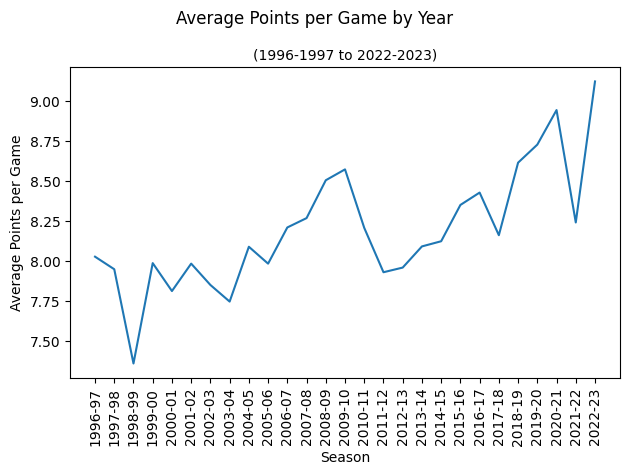

In [192]:
#creating line chart of avg scoring by season
plt.plot(scoring['season'], scoring['pts'])
plt.xlabel("Season")
plt.ylabel("Average Points per Game")
plt.suptitle("Average Points per Game by Year")
plt.title("(1996-1997 to 2022-2023)", fontsize= 10)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

4. Who are the top 10 scorers across all seasons and what teams did they play for?

In [193]:
# Rank all players by points scored and filter top 10
df['rank'] = df['pts'].rank(method='min', ascending=False)
top_scorers = df[df['rank'] <= 10][['player_name', 'team_abbreviation', 'pts', 'rank']].sort_values('rank')
top_scorers = top_scorers[['player_name', 'team_abbreviation', 'pts']]
print(top_scorers)

          player_name team_abbreviation   pts
10227    James Harden               HOU  36.1
4163      Kobe Bryant               LAL  35.4
10634    James Harden               HOU  34.3
12839     Joel Embiid               PHI  33.1
4302    Allen Iverson               PHI  33.0
12740     Luka Doncic               DAL  32.4
12564  Damian Lillard               POR  32.2
2847    Tracy McGrady               ORL  32.1
8013     Kevin Durant               OKC  32.0
11537   Stephen Curry               GSW  32.0


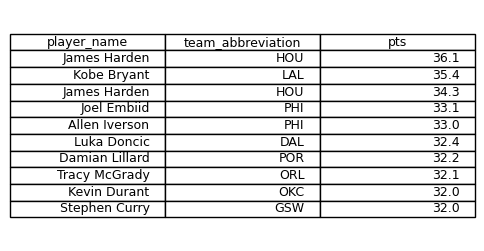

In [194]:
#create table
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('tight')
ax.axis('off')
ax.table(cellText= top_scorers.values, colLabels= top_scorers.columns, loc='center')

5. Which colleges produced the most players averaging 20+ PPG (top 5)?

In [195]:
#only players who scored 20+ ppg and went to college
pts_20 = df.loc[(df['pts'] >= 20.0) & (df['college'] != 'No College')]

In [196]:
#include players only once, count and sort
pts_20 = pts_20.drop_duplicates(subset=['player_id'])
college_20_pts = pts_20.groupby('college', as_index= False)['player_id'].count()
college_20_pts = college_20_pts.sort_values(by= 'player_id', ascending= False)

In [197]:
#ranking
college_20_pts['rank'] = college_20_pts['player_id'].rank(method= 'min', ascending= False)
college_20_pts = college_20_pts.loc[college_20_pts['rank'] <= 5]
college_20_pts = college_20_pts.rename(columns={'player_id': 'num_of_players'})
college_20_pts = college_20_pts[['college', 'num_of_players']]
print(college_20_pts)

        college  num_of_players
27     Kentucky              16
11         Duke              11
35     Michigan               6
9   Connecticut               6
67         UCLA               6


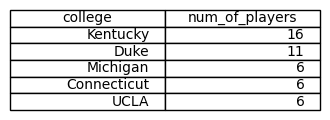

In [198]:
#create table
fig, ax = plt.subplots(figsize=(4, 1))
ax.axis('tight')
ax.axis('off')
ax.table(cellText= college_20_pts.values, colLabels= college_20_pts.columns, loc='center')

6. Does player height strongly correlate with rebounding success?

In [199]:
#create total rebound percentage metric
df['total_reb_pct'] = (df['oreb_pct'] + df['dreb_pct']) /2

In [200]:
#calculate correlation coefficient for all rebounding metrics
oreb_corr = df['player_height'].corr(df['oreb_pct'])
dreb_corr = df['player_height'].corr(df['dreb_pct'])
reb_corr = df['player_height'].corr(df['reb'])
reb_pct_corr = df['player_height'].corr(df['total_reb_pct'])

In [201]:
print(f"Offensive Rebound Percentage Correlation: {oreb_corr:.2f}")
print(f"Defensive Rebound Percentage Correlation: {dreb_corr:.2f}")
print(f"Rebounds per Game Correlation: {reb_corr:.2f}")
print(f"Total Rebound Percentage Correlation: {reb_pct_corr:.2f}")

Offensive Rebound Percentage Correlation: 0.59
Defensive Rebound Percentage Correlation: 0.61
Rebounds per Game Correlation: 0.42
Total Rebound Percentage Correlation: 0.68


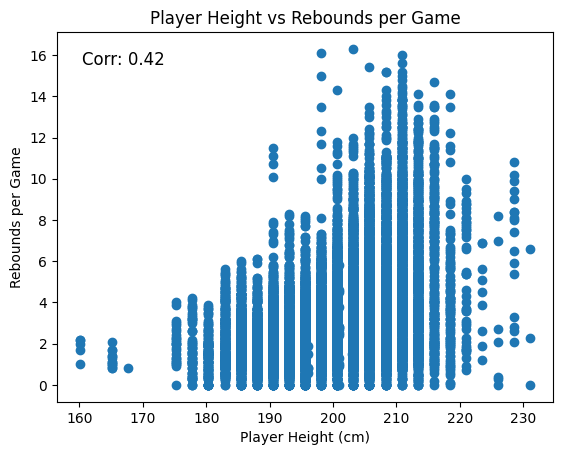

In [202]:
#height vs reb
plt.scatter(df['player_height'], df['reb'])
plt.xlabel("Player Height (cm)")
plt.ylabel("Rebounds per Game")
plt.title("Player Height vs Rebounds per Game")
plt.text(0.05, 0.95, f'Corr: {reb_corr:.2f}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top')
plt.show()

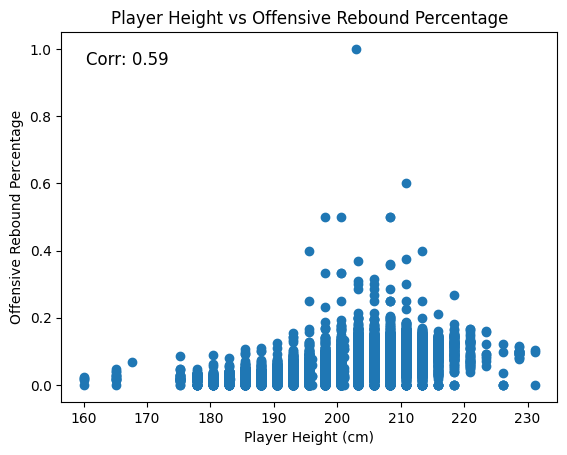

In [203]:
#height vs oreb_pct
plt.scatter(df['player_height'], df['oreb_pct'])
plt.xlabel("Player Height (cm)")
plt.ylabel("Offensive Rebound Percentage")
plt.title("Player Height vs Offensive Rebound Percentage")
plt.text(0.05, 0.95, f'Corr: {oreb_corr:.2f}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top')
plt.show()

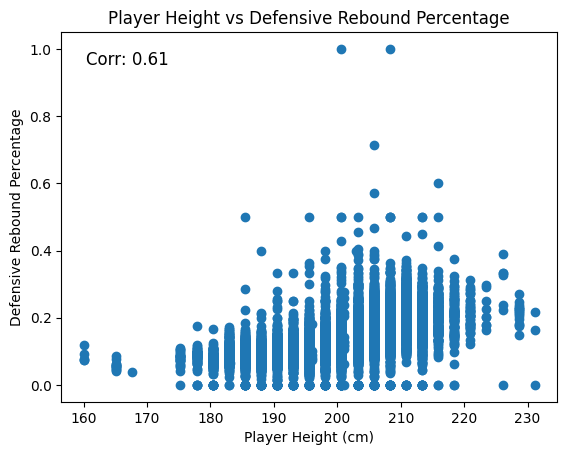

In [204]:
#height vs dreb_pct
plt.scatter(df['player_height'], df['dreb_pct'])
plt.xlabel("Player Height (cm)")
plt.ylabel("Defensive Rebound Percentage")
plt.title("Player Height vs Defensive Rebound Percentage")
plt.text(0.05, 0.95, f'Corr: {dreb_corr:.2f}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top')
plt.show()

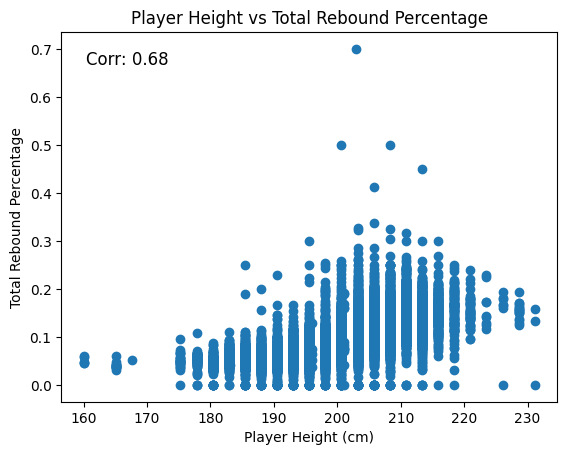

In [205]:
#height vs total_reb_pct
plt.scatter(df['player_height'], df['total_reb_pct'])
plt.xlabel("Player Height (cm)")
plt.ylabel("Total Rebound Percentage")
plt.title("Player Height vs Total Rebound Percentage")
plt.text(0.05, 0.95, f'Corr: {reb_pct_corr:.2f}', transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top')
plt.show()

7. Do high scorers also tend to have high assists?

In [206]:
#calculate the correlation between pts and ast
pts_ast_corr = df['pts'].corr(df['ast'])
print(f'Points vs Assists correlation: {pts_ast_corr:.2f}')

Points vs Assists correlation: 0.66


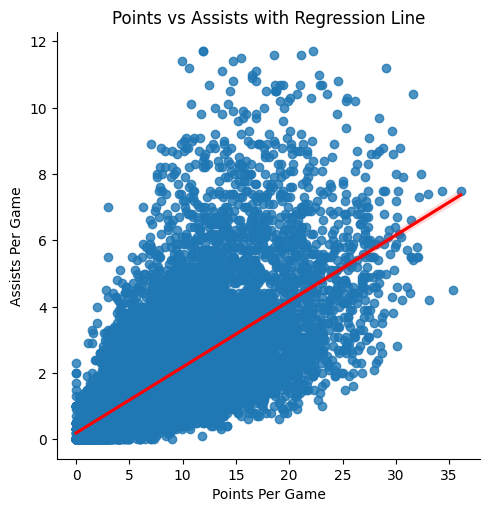

In [207]:
#create scatterplot with regression line
sns.lmplot(x='pts', y='ast', data=df, line_kws={"color": "red"})
plt.title('Points vs Assists with Regression Line')
plt.xlabel('Points Per Game')
plt.ylabel('Assists Per Game')
plt.show()

8. Is there a significant difference in PPG between top-10 draft picks and others?

In [208]:
top_10 = [1,2,3,4,5,6,7,8,9,10]

#create function to calculate weighted ppg
def weighted_ppg(group):
    return (group['pts'] * group['gp']).sum() / group['gp'].sum()

In [209]:
#create df with player name, career ppg, and draft number
career_ppg = pd.DataFrame(df.groupby('player_id').apply(weighted_ppg, include_groups= False))
career_ppg = career_ppg.merge(df, on= 'player_id').rename(columns= {0: 'ppg'})
career_ppg = career_ppg[['player_id', 'ppg', 'draft_number']].drop_duplicates()

In [210]:
#select points for top 10 picks
top_10_picks = career_ppg.loc[career_ppg['draft_number'].isin(top_10)]
top_10_picks_pts = top_10_picks['ppg']

#select points for non-top 10 picks
non_top_10_picks = career_ppg.loc[career_ppg['draft_number'].isin(top_10) == False]
non_top_10_picks_pts = non_top_10_picks['ppg']

In [211]:
#assumption of normality
print(f"Number of top-10 picks: {len(top_10_picks)}")
print(f"Number of non-top 10 picks: {len(non_top_10_picks)}")

Number of top-10 picks: 381
Number of non-top 10 picks: 2179


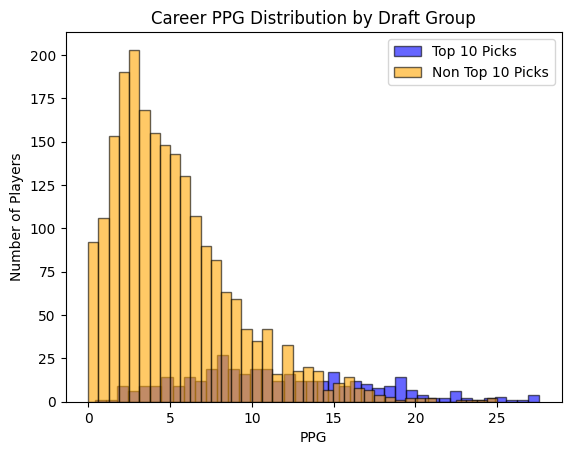

In [212]:
#Check normality with overlapping histograms
plt.hist(top_10_picks_pts, bins= 40, alpha= 0.6, label= 'Top 10 Picks', color= 'blue', edgecolor= 'black')
plt.hist(non_top_10_picks_pts, bins= 40, alpha= 0.6, label= 'Non Top 10 Picks', color= 'orange', edgecolor= 'black')
plt.title('Career PPG Distribution by Draft Group')
plt.xlabel('PPG')
plt.ylabel('Number of Players')
plt.legend()
plt.show()

In [213]:
#check assumption of equal variances with Levene's test
print(stats.levene(top_10_picks_pts, non_top_10_picks_pts))

LeveneResult(statistic=128.46563620759417, pvalue=4.332624952707754e-29)


In [214]:
#run Welch's t-test
print(stats.ttest_ind(top_10_picks_pts, non_top_10_picks_pts, equal_var= False))

TtestResult(statistic=21.09453583461285, pvalue=7.811018051550017e-69, df=441.63646712733174)


In [215]:
#calculate Cohen's d to understand effect size
def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    pooled_std = np.sqrt(((nx - 1) * np.std(x, ddof=1) ** 2 + (ny - 1) * np.std(y, ddof=1) ** 2) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std

print(f"Cohen's d: {cohens_d(top_10_picks_pts, non_top_10_picks_pts):.2f}")

Cohen's d: 1.54


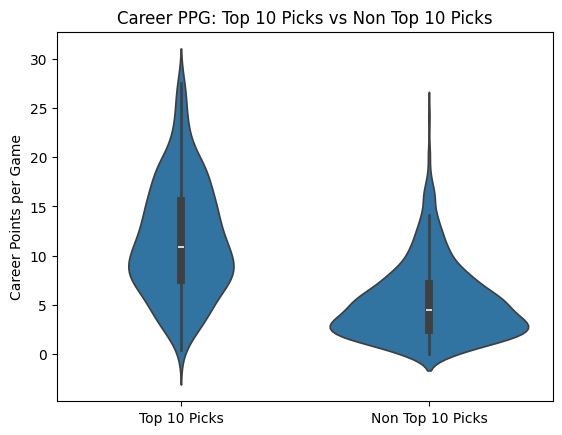

In [216]:
#Convert to DataFrames with a group label
df_top10 = pd.DataFrame({
    'points': top_10_picks_pts.squeeze(),
    'group': 'Top 10 Picks'
})

df_non_top10 = pd.DataFrame({
    'points': non_top_10_picks_pts.squeeze(),
    'group': 'Non Top 10 Picks'
})

#Combine the two
df_combined = pd.concat([df_top10, df_non_top10], ignore_index=True)

#Plot
sns.violinplot(x='group', y='points', data=df_combined, inner='box')
plt.title('Career PPG: Top 10 Picks vs Non Top 10 Picks')
plt.ylabel('Career Points per Game')
plt.xlabel('')
plt.show()

9. Predict PPG

In [217]:
#create next season ppg column
df['next_ppg'] = df.sort_values(by= 'season').groupby(by= 'player_id', as_index= False)['pts'].shift(-1)

In [218]:
#create df with years played, exclude single season players and final seasons
seasons = pd.DataFrame(df['player_id'].value_counts())
seasons = seasons.loc[seasons['count'] > 1]
linear_df = df.loc[(df['player_id'].isin(seasons.index)) & (df['next_ppg'].isnull() == False)].copy()

In [ ]:
features = linear_df[['age', 'player_height', 'draft_number', 'pts', 'ast', 'usg_pct', 'ts_pct', 'ast_pct']]

X = features
y = linear_df['next_ppg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state= 1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#evaluate
r_squared = model.score(X_test, y_test)
rmse = root_mean_squared_error(y_test, y_pred)

print(f'R-squared: {r_squared:.2f}')
print(f'RMSE: {rmse:.2f}')

R-squared: 0.76
RMSE: 2.98
